# Handwritting - Page Detection
Finding the locations of characters

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("Pandas: " + pd.__version__)

OpenCV: 3.1.0-dev
Numpy: 1.11.2
Pandas: 0.17.1


In [2]:
SMALL_HEIGHT = 800         # Image scaling
IMG = "test"               # Image name/number

### Help Functions

In [3]:
def implt(img, cmp=None, t=''):
    """ Show image using plt """
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()


def resize(img, height=SMALL_HEIGHT, allways=False):
    """ Resize image to given height """
    if (img.shape[0] > SMALL_HEIGHT or allways):
        rat = height / img.shape[0]
        return cv2.resize(img, (int(rat * img.shape[1]), height))
    
    return img


def ratio(img, height=SMALL_HEIGHT):
    return img.shape[0] / height

## Finding the text areas and characters

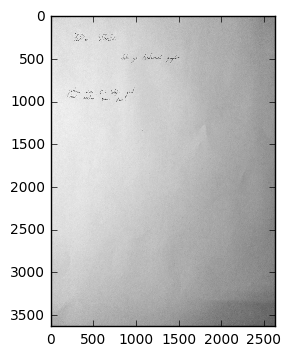

In [4]:
# Loading image (converting to RGB)
image = cv2.cvtColor(cv2.imread("data/textdet/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
implt(img, 'gray')

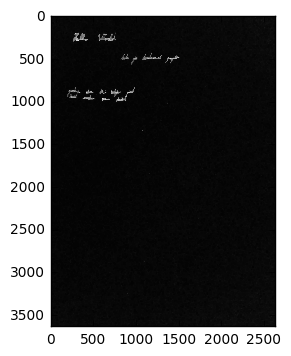

In [5]:
def sobelDetect(channel):
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return sobel


def edgeDetect(im):
    """ Edge detection """
    return np.max(np.array([sobelDetect(im[:,:, 0]), sobelDetect(im[:,:, 1]), sobelDetect(im[:,:, 2]) ]), axis=0)

blurred = cv2.GaussianBlur(image, (5, 5), 0)
edgeImg = edgeDetect(blurred)
img = np.uint8(edgeImg)
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((15,15), np.uint8))
implt(closing, 'gray')

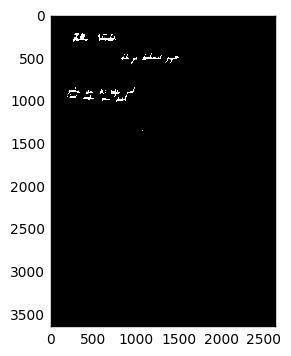

In [6]:
ret, bwImage = cv2.threshold(closing, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
implt(bwImage, 'gray')

In [7]:
## NOT IN USE ##
def delLines(gray):
    linek = np.ones((1,11),np.uint8)
    x = cv2.morphologyEx(gray, cv2.MORPH_OPEN, linek ,iterations=1)
    i = gray-x
    closing = cv2.morphologyEx(dil, cv2.MORPH_CLOSE, np.ones((17,17), np.uint8))
    implt(closing, 'gray', 'Del Lines')
    return closing


def delBigAreas(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # ret, gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 101, 3)    
    implt(gray, 'gray')
    
    gray2 = gray.copy()
    mask = np.zeros(gray.shape,np.uint8)
    
    im2, contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        if (200 < cv2.contourArea(cnt) < 5000):
            cv2.drawContours(img,[cnt],0,(0,255,0),2)
            cv2.drawContours(mask,[cnt],0,255,-1)
            
    implt(mask)
    implt(img)

In [8]:
def textDetect(img):
    """ Text detection using contours """
    small = resize(img, 1200)
    # Horizontal closing, @TODO
    # lineKelner = np.ones((1, 9), np.uint8)
    # conn = cv2.morphologyEx(small, cv2.MORPH_CLOSE, lineKelner)
    
    # Finding contours
    mask = np.zeros(small.shape, np.uint8)
    im2, cnt, hierarchy = cv2.findContours(np.copy(small), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE) # Point ???
    implt(img, 'gray')
    index = 0
    
    boundingBoxes = np.array([0,0,0,0])
    
    # For contours drawing
    small = cv2.cvtColor(small, cv2.COLOR_GRAY2RGB)
    
    # CCOMP hierarchy: [Next, Previous, First Child, Parent]
    # cv2.RETR_CCOMP - contours into 2 levels
    # Go through all contours in top level
    while (index >= 0):
        x,y,w,h = cv2.boundingRect(cnt[index])
        cv2.drawContours(mask, cnt, index, (255, 255, 255), cv2.FILLED)
        maskROI = mask[y:y+h, x:x+w]
        # Ratio of white pixels to area of bounding rectangle
        r = cv2.countNonZero(maskROI) / (w * h)
        
        # Limits for text
        if r > 0.2 and w > 10 and h > 10:
            cv2.rectangle(small, (x, y),(x+w,y+h), (0, 255, 0), 2)
            boundingBoxes = np.vstack((boundingBoxes, np.array([x, y, x+w, y+h])))
            
        index = hierarchy[0][index][0]
        
    implt(small, t='Bounding rectangles')
    
    bBoxes = boundingBoxes.dot(ratio(image, 1200)).astype(np.int64)
    return bBoxes[1:]  
    

def textDetectWatershed(thresh):
    """ Text detection using watershed algorithm """
    # According to: http://docs.opencv.org/trunk/d3/db4/tutorial_py_watershed.html
    img = cv2.cvtColor(cv2.imread("data/textdet/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
    
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 3)

    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.01*dist_transform.max(),255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers += 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0
    
    markers = cv2.watershed(img, markers)
    implt(markers, t='Markers')

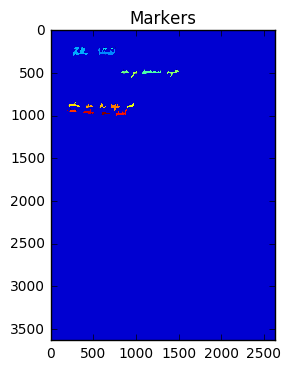

In [9]:
# Testing different alg
textDetectWatershed(bwImage)

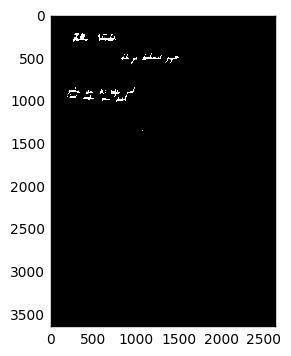

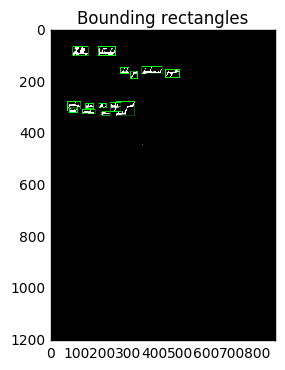

In [10]:
# Get text bounding boxes
bBoxes = textDetect(bwImage)

In [11]:
# Import Widgets
import ipywidgets as widgets
from IPython.display import display, clear_output
import time # For timestamp


class Cycler:
    """ Cycle through boxes, save data """
    width = 30
    height = 50
    step = 5
    
    def __init__(self, image, boxes):
        self.boxes = boxes
        self.image = image
        self.index = 0
        self.pos = 0
        self.actual = image
        self.actualPos = image
        
    def saveLetter(self, b):
        self.save(b, val=0)
        
    def save(self, b, val=1):
        cv2.imwrite("data/gapdet/%s/%s.jpg" % (val, time.time()), cv2.cvtColor(self.actualPos, cv2.COLOR_BGR2RGB))
        self.nextPos(b)
        
    def prevPos(self, b):
        self.nextPos(b, step=-self.step)
        
    def nextSmallPos(self, b): 
        self.nextPos(b, step=2)
        
    def nextPos(self, b, step=0):
        if step == 0:
            step = self.step
            
        clear_output()
        
        if self.pos < len(self.actual[0]) - self.width:
            img = self.actual[0:self.height, self.pos:self.pos + self.width]
            self.actualPos = img
            ii = np.copy(img)
            cv2.line(ii,((int)(self.width/2),0),((int)(self.width/2), self.height), (0,255,0), 1)
            implt(ii) 
            self.pos += step
        else:
            if self.nextImg() != -1:
                self.pos = 0
            else:
                print("END")

    def nextImg(self):
        if self.index < len(self.boxes):
            b = self.boxes[self.index]
            x1, y1, x2, y2 = b
            img = image[y1:y2, x1:x2]
            img = resize(img, self.height, True)
            implt(img)
            self.actual = img
            self.index += 1
            return 0
        else:
            print("END")
            return -1


bGap = widgets.Button(description="Gap")
bLet = widgets.Button(description="Letter")
bNex = widgets.Button(description="Next")
bNexS = widgets.Button(description="Next Small")
bPre = widgets.Button(description="Prev")
bNexi = widgets.Button(description="Next Image")
display(bGap, bLet, bNex, bNexS, bPre, bNexi)

# Class cycling through text positions
cycler = Cycler(image, bBoxes)

def nextImg(b):
    clear_output()
    cycler.nextImg()
    
bGap.on_click(cycler.save)
bLet.on_click(cycler.saveLetter)
bPre.on_click(cycler.prevPos)
bNex.on_click(cycler.nextPos)
bNexS.on_click(cycler.nextSmallPos)
bNexi.on_click(nextImg)

In [12]:
# EXPERIMENTS #

# for b in bBoxes:
#     img = image
#     x1, y1, x2, y2 = b
#     img = image[y1:y2, x1:x2]
#     print(img.shape[0])
#     implt(img)
#     ii = img.copy()
#     ii2 = img.copy()
#     img = cv2.bilateralFilter(img,9,75,75)
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
#     implt(gray, 'gray', 'GrayB')
#     # convulation on different image???
#     th = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51, 3) 
#     implt(th, 'gray', 'Gray')
    

#     whiteSum = np.sum(th==255, axis=0)

#     plt.plot(whiteSum)
#     plt.title('White pixel sum')
#     plt.grid(True)
#     plt.show()

## END OF WORKING - GrayB ###
    
    


    # Delete nejnižší pixely, funkce na hledání nejnižšího pixelu...
    # a postupné delet dokud nepřibude nová contura
    
    # detekce char vs non char zvetšovat bounding obdelnik dokud se zvetsuje jistota...
    # -> machine learning



# LABELING BY VERTICAL CLOSING...

# kernel = np.ones((100,3),np.uint8)

# blackhat = cv2.morphologyEx(th, cv2.MORPH_BLACKHAT, kernel)
# blackhat = cv2.morphologyEx(blackhat, cv2.MORPH_BLACKHAT, kernel)
# i = cv2.medianBlur(blackhat, 5)
# kernel = np.ones((img.shape[0]+1000,5),np.uint8)
# closing = cv2.morphologyEx(i, cv2.MORPH_CLOSE, kernel)

# implt(blackhat, 'gray', '2-Blackhat')
# implt(i, 'gray', '2-Blackhat + mBlur')
# implt(closing, 'gray', '2-Blackhat + mBlur + closing')




# for b in bBoxes:
#     print(b)
#     img = image
#     x1, y1, x2, y2 = b
#     img = image[y1:y2, x1:x2]
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     edges = cv2.Canny(gray,50,150,apertureSize = 3)
#     implt(edges, 'gray')
#     kernel = np.ones((5,5),np.uint8)
#     closing = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
#     blackhat = cv2.morphologyEx(edges, cv2.MORPH_BLACKHAT, kernel)
    
#     implt(blackhat, 'gray')